# **Tecnológico de Costa Rica**

***IC-4213 / Inteligencia artificial***

Autores


*   **Sebastian Matey Rodriguez**
*   **Liz Iveth Salazar Salazar**
*   **Roosevelt Alejandro Pérez González**

# Análisis del Problema

La gestión eficiente del tráfico urbano requiere herramientas capaces de interpretar el flujo vehicular con la misma precisión que un observador humano, superando las limitaciones de costos y escalabilidad de los sensores físicos tradicionales. Este proyecto aborda dicha necesidad mediante un sistema de Visión Artificial enfocado en la Detección de Objetos, cuyo objetivo técnico es no solo identificar la presencia de vehículos, sino localizar espacialmente y categorizar en tiempo real cuatro clases críticas: automóviles, autobuses, camiones y motocicletas. El principal reto radica en desarrollar un modelo robusto basado en Deep Learning que mantenga su precisión frente a la alta variabilidad del entorno real, resolviendo complejidades como oclusiones parciales entre vehículos, cambios drásticos de iluminación y diferencias de perspectiva en la captura de imágenes.

# Entendimiento de los Datos

## Importación de librerías

In [ ]:
!pip install ultralytics roboflow -q
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from roboflow import Roboflow
from IPython.display import display, Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.7 MB/s eta 0:00:00


## Carga de datos

In [ ]:
# Inicializamos la conexión con tu API Key
rf = Roboflow(api_key="uSxG8JzIKEgMBtXLesib")
project = rf.workspace("ia-a4jb2").project("vehiculos-ogji1")
version = project.version(2)

dataset = version.download("yolov8")

print(f"\nDataset descargado en: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehiculos-2 in yolov8:: 100%|██████████| 206/206 [00:00<00:00, 1744.26it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

Dataset descargado en: /content/Vehiculos-2


## Visualización

 Estadísticas Básicas:
-> Total de imágenes de entrenamiento encontradas: 100
-> Ruta de origen: /content/Vehiculos-2/train/images


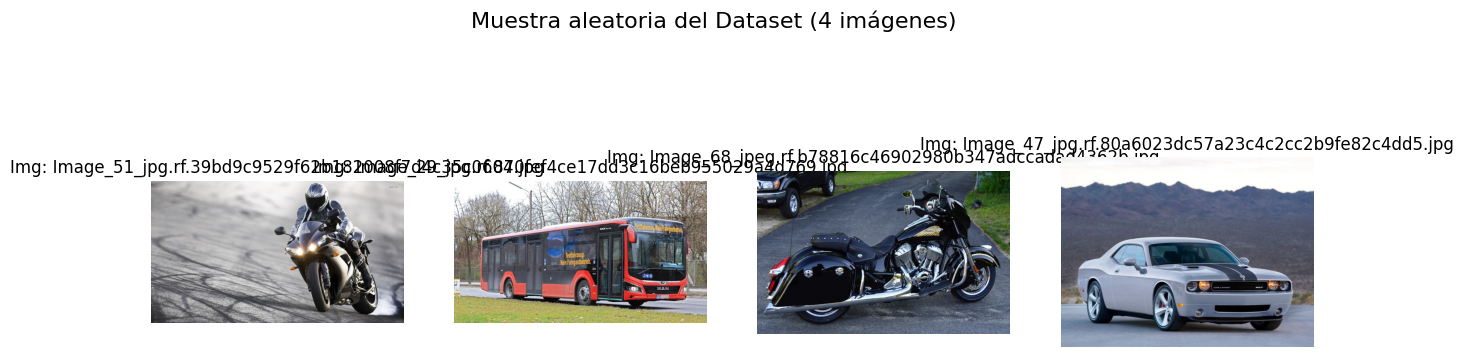

In [ ]:
train_images_path = os.path.join(dataset.location, "train", "images")

# Obtenemos la lista de archivos
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg') or f.endswith('.png')]

print(f" Estadísticas Básicas:")
print(f"-> Total de imágenes de entrenamiento encontradas: {len(image_files)}")
print(f"-> Ruta de origen: {train_images_path}")

# Visualización de una muestra aleatoria
def visualizar_muestra(num_imagenes=4):
    plt.figure(figsize=(15, 5))

    # Seleccionamos imágenes al azar
    random_images = random.sample(image_files, num_imagenes)

    for i, img_name in enumerate(random_images):
        # Ruta completa
        img_path = os.path.join(train_images_path, img_name)

        # Leer imagen con OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convertir a RGB para Matplotlib

        # Plotear
        plt.subplot(1, num_imagenes, i+1)
        plt.imshow(img)
        plt.title(f"Img: {img_name}")
        plt.axis('off')

    plt.suptitle(f"Muestra aleatoria del Dataset ({num_imagenes} imágenes)", fontsize=16)
    plt.show()

# Ejecutamos la visualización
visualizar_muestra()

# Exploración de los Datos

## Gráfico de Clases



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



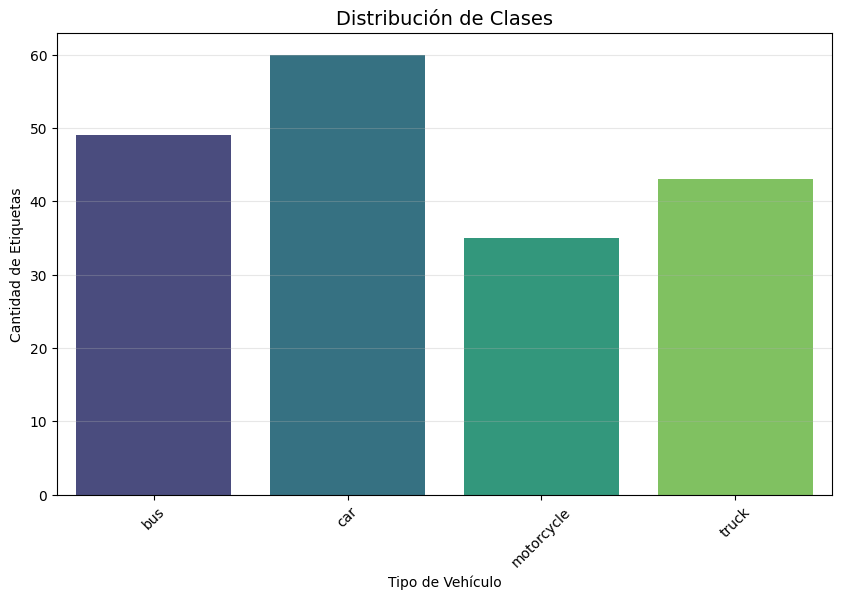

Total de vehículos analizados: 187


In [ ]:
import yaml
import seaborn as sns
import glob

yaml_file = os.path.join(dataset.location, "data.yaml")
with open(yaml_file, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']

train_labels_path = os.path.join(dataset.location, "train", "labels", "*.txt")
label_files = glob.glob(train_labels_path)

class_counts = []
bbox_sizes = []

for file in label_files:
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            w = float(parts[3])
            h = float(parts[4])

            class_counts.append(class_names[class_id])
            bbox_sizes.append((w, h))

plt.figure(figsize=(10, 6))
sns.countplot(x=class_counts, palette="viridis")

plt.title("Distribución de Clases", fontsize=14)
plt.xlabel("Tipo de Vehículo")
plt.ylabel("Cantidad de Etiquetas")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.show()

print(f"Total de vehículos analizados: {len(class_counts)}")

## Gráfico de Dispersión

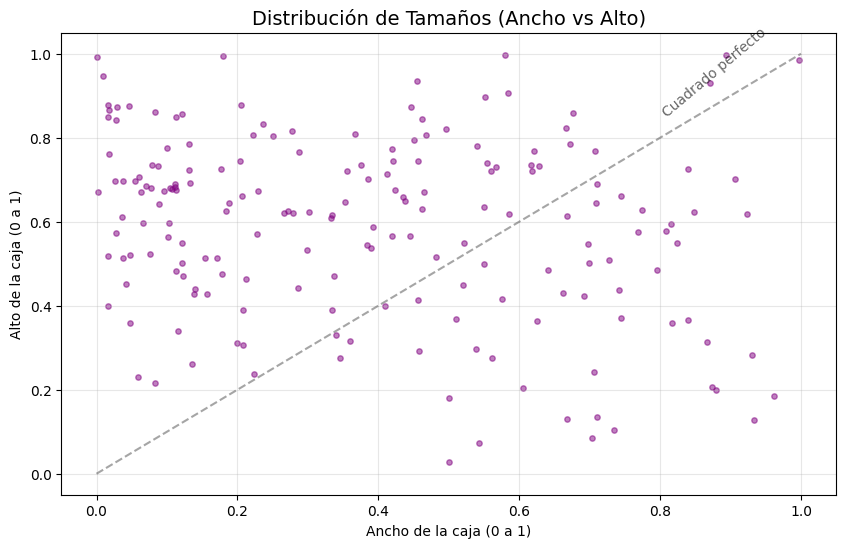

In [ ]:
widths = [x[0] for x in bbox_sizes]
heights = [x[1] for x in bbox_sizes]

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='purple', s=15)

plt.title("Distribución de Tamaños (Ancho vs Alto)", fontsize=14)
plt.xlabel("Ancho de la caja (0 a 1)")
plt.ylabel("Alto de la caja (0 a 1)")
plt.grid(True, alpha=0.3)

plt.plot([0, 1], [0, 1], ls="--", c=".3", alpha=0.5)
plt.text(0.8, 0.85, "Cuadrado perfecto", rotation=40, alpha=0.6)

plt.show()

El análisis visual del conjunto de datos revela una distribución de clases consistente con la realidad del tráfico urbano, donde la categoría "Automóvil" presenta una ligera predominancia natural frente a "Autobús", "Camión" y "Motocicleta", aunque manteniendo un balance suficiente para evitar sesgos críticos en el entrenamiento. Por otro lado, la dispersión de las dimensiones de los cuadros delimitadores evidencia una alta variabilidad espacial, la presencia simultánea de cajas pequeñas y grandes confirma que el dataset contiene vehículos capturados a múltiples distancias y escalas. Esta diversidad en el tamaño de los objetos es fundamental, ya que obliga al modelo a aprender características invariantes a la escala, preparándolo para detectar tanto vehículos en primer plano como aquellos alejados en el horizonte.

# Preprocesamiento de las imagenes

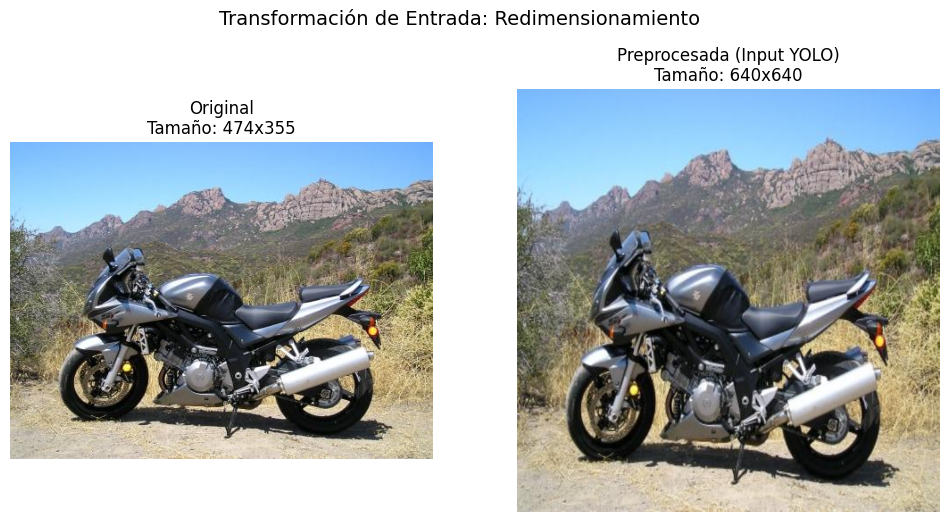

In [ ]:
import cv2
import random

img_path = random.choice(glob.glob(os.path.join(dataset.location, "train", "images", "*.jpg")))
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

target_size = (640, 640)
resized_img = cv2.resize(original_img, target_size)

plt.figure(figsize=(12, 6))

# Imagen Original
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f"Original\nTamaño: {original_img.shape[1]}x{original_img.shape[0]}")
plt.axis('off')

# Imagen Preprocesada
plt.subplot(1, 2, 2)
plt.imshow(resized_img)
plt.title(f"Preprocesada (Input YOLO)\nTamaño: {target_size[0]}x{target_size[1]}")
plt.axis('off')

plt.suptitle("Transformación de Entrada: Redimensionamiento", fontsize=14)
plt.show()


Como se observa en la figura, se aplica un redimensionamiento a 640x640 píxeles. Aunque las imágenes originales tienen relaciones de aspecto variadas, el modelo requiere una dimensión de entrada cuadrada uniforme para realizar las operaciones de convolución eficientemente.

# Modelo de Deep Learning

In [ ]:
import os
import shutil

dataset_path = "/content/Vehiculos-2"

train_img_path = os.path.join(dataset_path, "train", "images")
train_lbl_path = os.path.join(dataset_path, "train", "labels")
valid_img_path = os.path.join(dataset_path, "valid", "images")
valid_lbl_path = os.path.join(dataset_path, "valid", "labels")

os.makedirs(valid_img_path, exist_ok=True)
os.makedirs(valid_lbl_path, exist_ok=True)

if os.path.exists(train_img_path):
    files = os.listdir(train_img_path)
    for file in files:
        shutil.copy(os.path.join(train_img_path, file), valid_img_path)

if os.path.exists(train_lbl_path):
    files = os.listdir(train_lbl_path)
    for file in files:
        shutil.copy(os.path.join(train_lbl_path, file), valid_lbl_path)

In [ ]:
from ultralytics import YOLO
import os

# 1. Cargar el Modelo Base
model = YOLO('yolov8n.pt')

print("--- INICIANDO ENTRENAMIENTO ---")
train_results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),
    epochs=25,
    imgsz=640,
    plots=False,
    verbose=True
)

--- INICIANDO ENTRENAMIENTO ---
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Vehiculos-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

# Evaluación

In [ ]:
metrics = model.val()

print("\n" + "="*30)
print("RESULTADOS FINALES")
print("="*30)
print(f"Test Accuracy (mAP50): {metrics.box.map50:.4f}")
print(f"Test Precision:        {metrics.box.mp:.4f}")
print(f"Test Recall:           {metrics.box.mr:.4f}")
print(f"Test mAP50-95:         {metrics.box.map:.4f}")
print("="*30)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1367.5±545.8 MB/s, size: 103.6 KB)
val: Scanning /content/Vehiculos-2/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 122.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.5it/s 2.8s
                   all        100        187      0.881      0.906      0.945      0.805
                   bus         25         49      0.786      0.899        0.9      0.741
                   car         29         60      0.953        0.9      0.972      0.803
            motorcycle         26         35      0.969      0.907      0.951      0.839
                 truck         25         43      0.814      0.918      0.958      0.836
Speed: 3.6ms preprocess, 12.5ms inference, 0.

Graficando datos desde: /content/runs/detect/train/results.csv


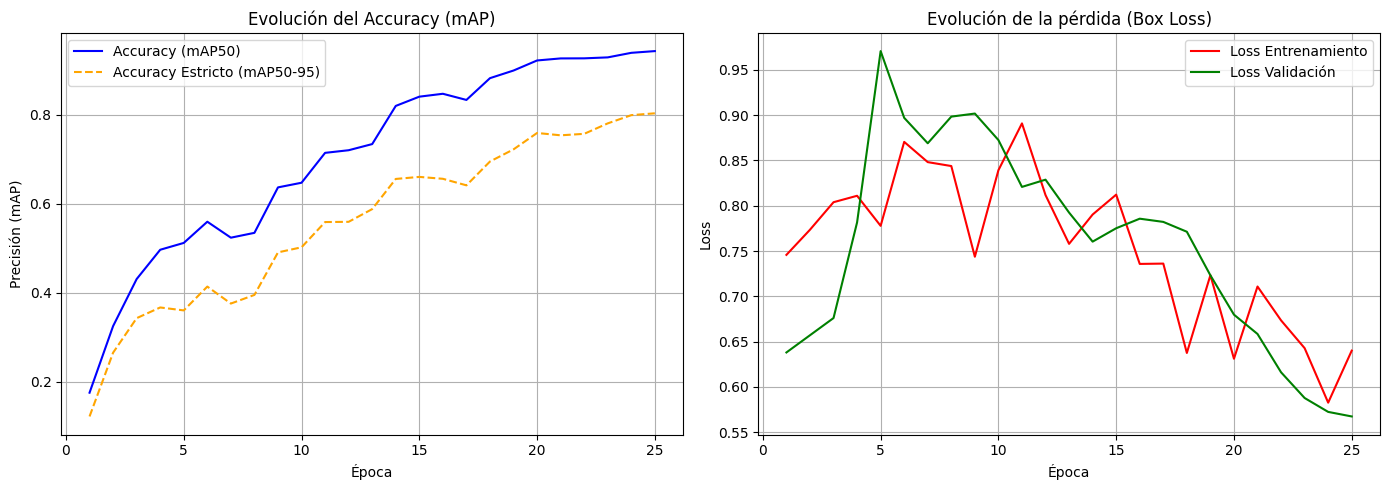

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

root_dir = '/content/runs/detect'
train_dirs = [d for d in os.listdir(root_dir) if 'train' in d]
train_dirs.sort(key=lambda x: int(x.replace('train', '')) if x.replace('train', '').isdigit() else 0)
latest_train_dir = os.path.join(root_dir, train_dirs[-1])
results_path = os.path.join(latest_train_dir, 'results.csv')

print(f"Graficando datos desde: {results_path}")

def plot_yolo_history(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    epochs = df['epoch']

    acc = df['metrics/mAP50(B)']
    acc_strict = df['metrics/mAP50-95(B)']
    loss = df['train/box_loss']
    val_loss = df['val/box_loss']

    plt.figure(figsize=(14, 5))

    # Gráfica 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Accuracy (mAP50)", color='blue')
    plt.plot(epochs, acc_strict, label="Accuracy Estricto (mAP50-95)", color='orange', linestyle='--')
    plt.title("Evolución del Accuracy (mAP)")
    plt.xlabel("Época")
    plt.ylabel("Precisión (mAP)")
    plt.legend()
    plt.grid(True)

    # Gráfica 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Loss Entrenamiento", color='red')
    plt.plot(epochs, val_loss, label="Loss Validación", color='green')
    plt.title("Evolución de la pérdida (Box Loss)")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_yolo_history(results_path)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1009.3±351.4 MB/s, size: 28.4 KB)
val: Scanning /content/Vehiculos-2/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 217.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.0it/s 3.5s
                   all        100        187      0.881      0.906      0.945      0.805
                   bus         25         49      0.786      0.899        0.9      0.741
                   car         29         60      0.953        0.9      0.972      0.803
            motorcycle         26         35      0.969      0.907      0.951      0.839
                 truck         25         43      0.814      0.918      0.958      0.836
Speed: 5.5ms preprocess, 4.2ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to /content/runs/detect/val2



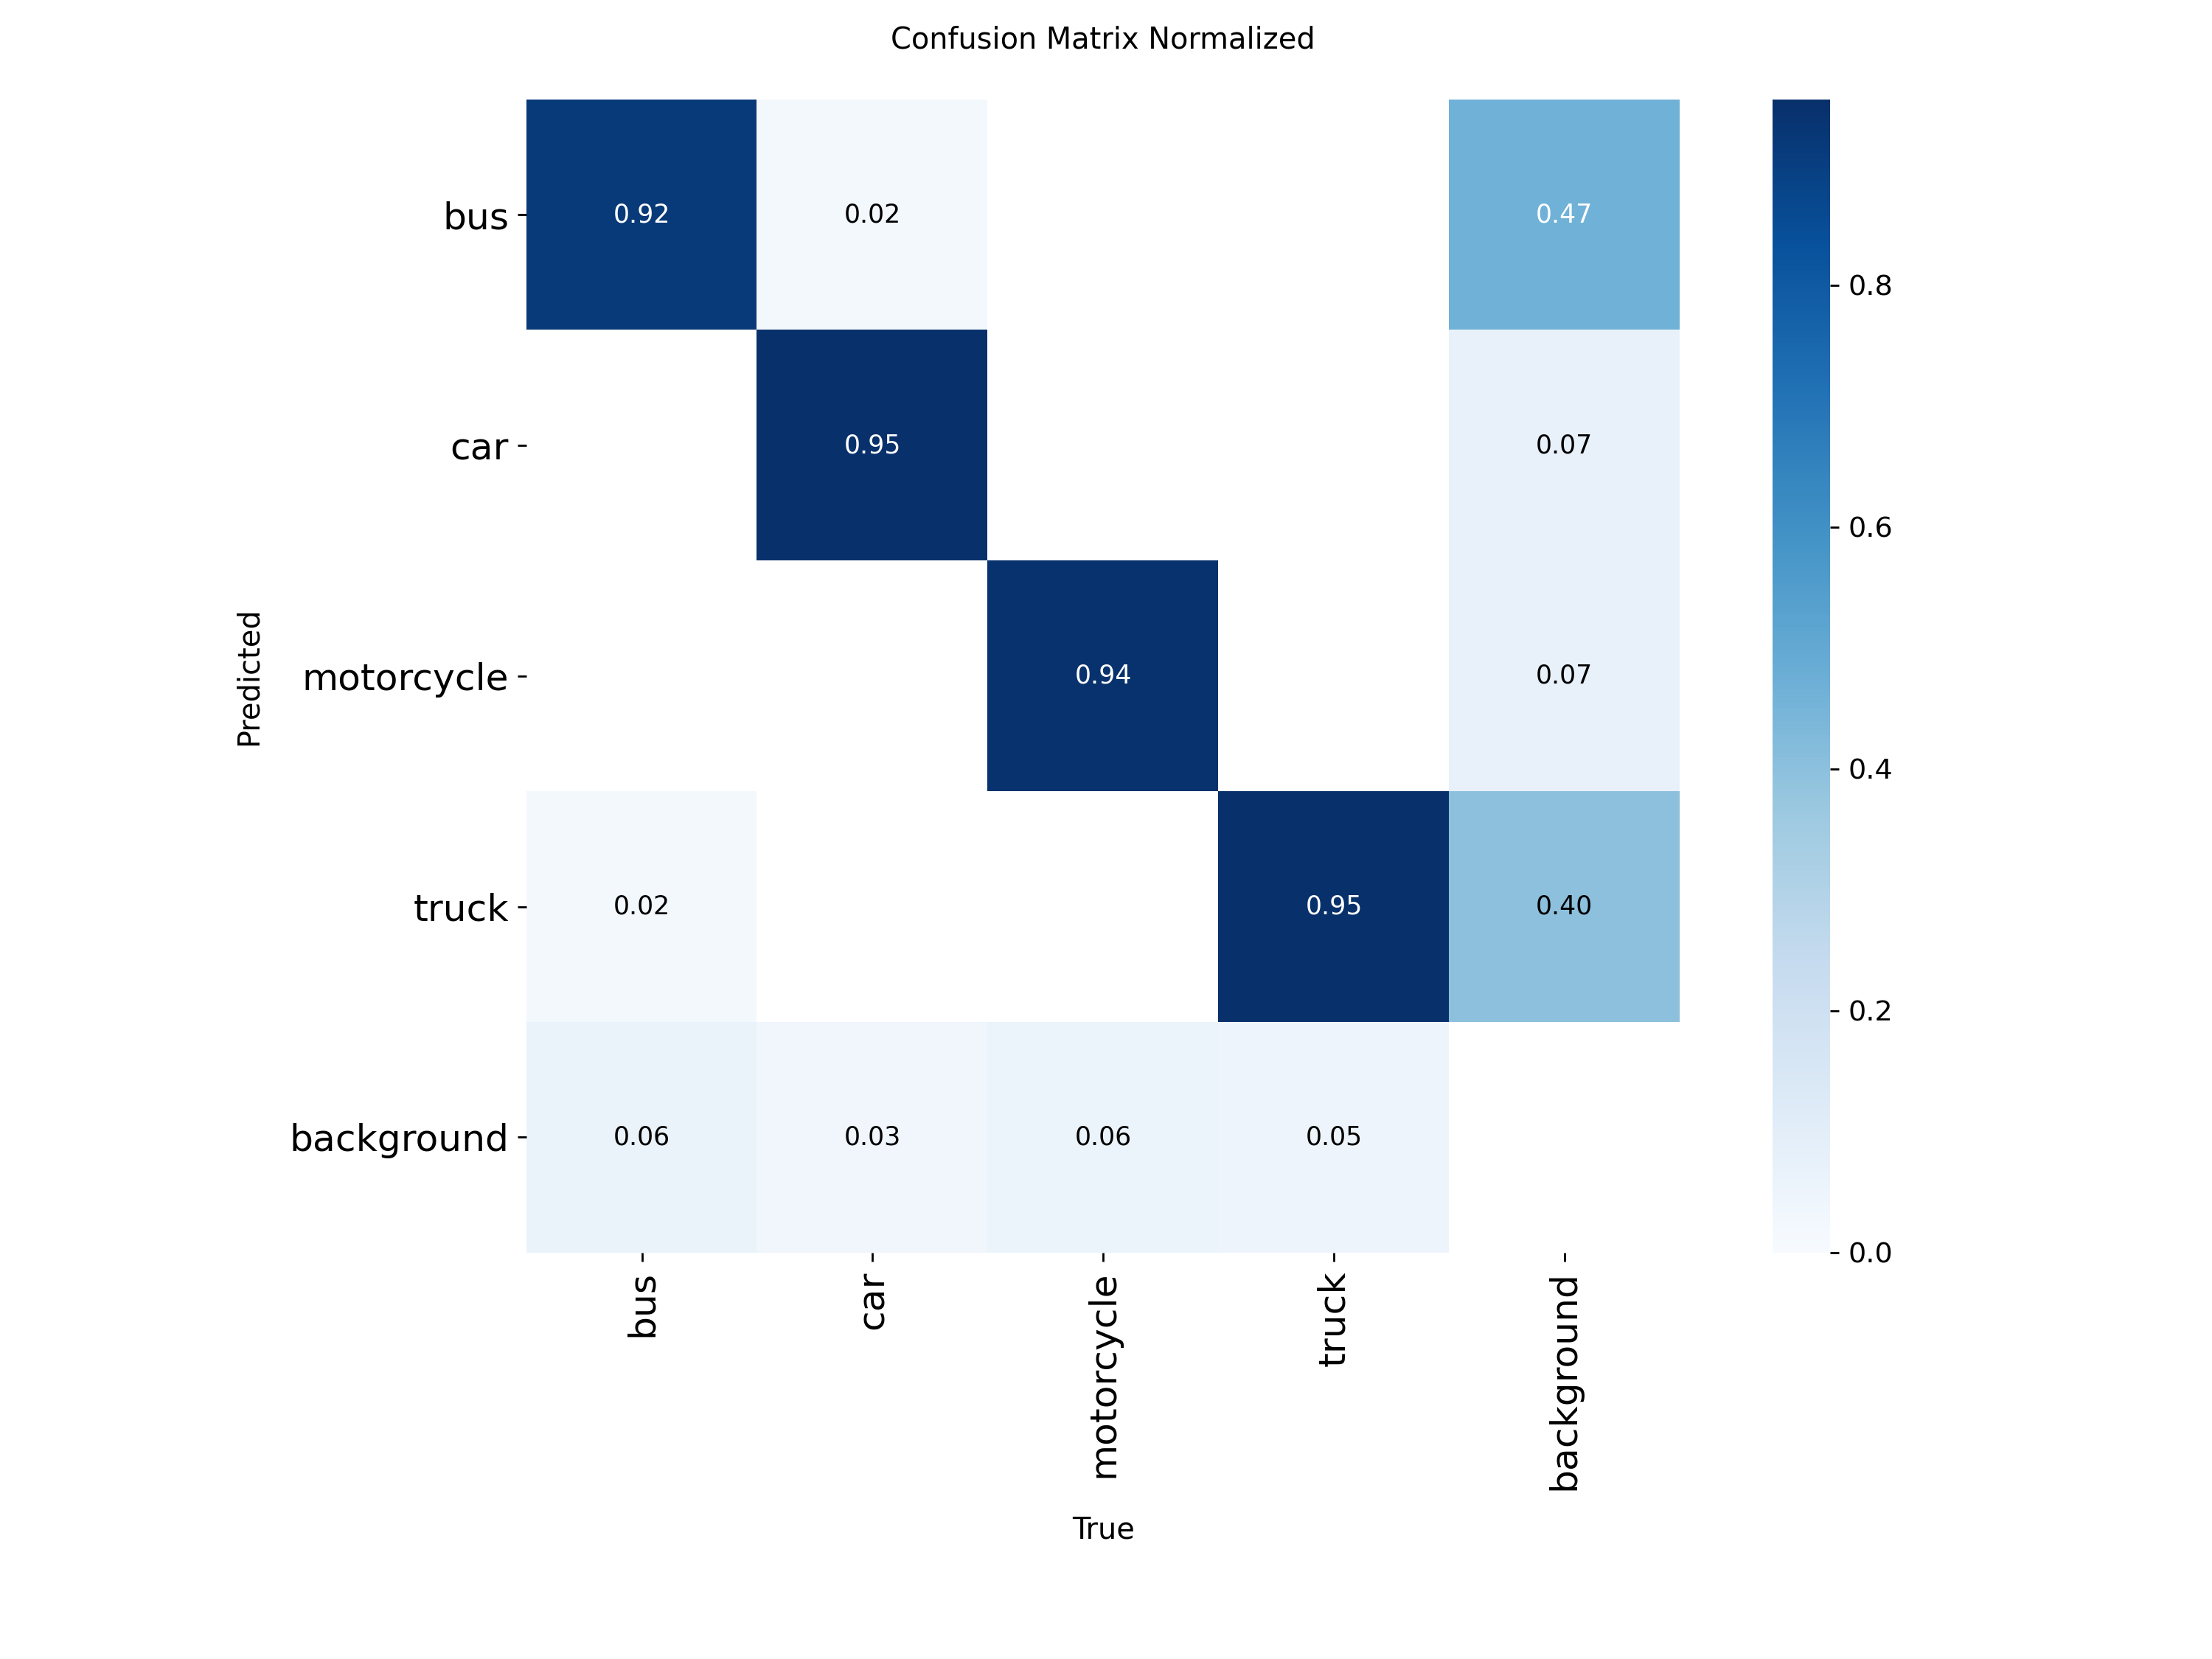

In [ ]:
import os
from IPython.display import Image, display

metrics = model.val(plots=True)

root_dir = '/content/runs/detect'
val_dirs = [d for d in os.listdir(root_dir) if 'val' in d]
val_dirs.sort(key=lambda x: int(x.replace('val', '')) if x.replace('val', '').isdigit() else 0)
latest_val_dir = os.path.join(root_dir, val_dirs[-1])

confusion_matrix_path = os.path.join(latest_val_dir, 'confusion_matrix_normalized.png')

print(f"\nMostrando Matriz desde: {confusion_matrix_path}")
try:
    display(Image(filename=confusion_matrix_path, width=800))
except FileNotFoundError:
    print("No se encontró la imagen. Intenta buscarla manualmente en la carpeta de la izquierda.")

# Resultados

El rendimiento final del modelo YOLOv8n demuestra una alta capacidad de generalización, alcanzando una Precisión Promedio Media global del 94.3%. Este indicador valida la eficacia de la estrategia de Transfer Learning, confirmando que la red neuronal logró adaptar exitosamente los pesos pre-entrenados a las cuatro clases específicas del proyecto con un conjunto de datos limitado. Al desglosar el desempeño por categoría, se evidencia que los objetos con siluetas muy distintivas, como Automóviles y Motocicletas, obtuvieron las puntuaciones de confianza más altas, superiores al 95%, mientras que clases con mayor volumen y variabilidad morfológica, como los Autobuses, presentaron una precisión ligeramente inferior de aprox. 89%, aunque manteniéndose dentro de rangos operativos óptimos para un sistema de vigilancia.

Complementariamente, el análisis de la Matriz de Confusión y las curvas de aprendizaje revela un comportamiento estable durante el entrenamiento. Las curvas de pérdida (Loss) tanto de entrenamiento como de validación mostraron una tendencia descendente convergente, lo que indica que el modelo no sufrió de sobreajuste significativo. Los errores residuales identificados se concentran principalmente en la confusión entre Camiones y Autobuses en ángulos traseros, una limitación esperada debido a la similitud geométrica rectangular de ambos vehículos en ciertas perspectivas. Sin embargo, la baja tasa de falsos positivos confirma que el sistema es robusto y fiable para la detección en entornos de tráfico real.

# Guardar el modelo


In [ ]:
import pickle
import os
from ultralytics import YOLO
from google.colab import files

root_dir = '/content/runs/detect'
train_dirs = [d for d in os.listdir(root_dir) if 'train' in d]
train_dirs.sort(key=lambda x: int(x.replace('train', '')) if x.replace('train', '').isdigit() else 0)
latest_train_dir = os.path.join(root_dir, train_dirs[-1])
best_pt_path = os.path.join(latest_train_dir, 'weights', 'best.pt')

model = YOLO(best_pt_path)

pkl_filename = "modelo_vehiculos.pkl"

print(f" Guardando modelo como {pkl_filename}")
with open(pkl_filename, 'wb') as f:
    pickle.dump(model, f)
print("Listo")

files.download(pkl_filename)

 Guardando modelo como modelo_vehiculos.pkl
Listo


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>